# VQE を利用しての分子シミュレーションを行う

このチュートリアルでは、Variational Quantum Eigensolver (VQE)とその利用の狙いを紹介し、必要な理論を説明します。また、分子の基底状態エネルギーを見つけるための実装例を紹介します。

## 内容
1. [はじめに](#introduction)
2. [量子力学での変分法](#varmethod)
    1. [数学的背景](#backgroundmath)
    2. [基底状態の下限](#groundstate)
3. [Variational Quantum Eigensolver](#vqe)
    1. [変分フォーム](#varforms)
    2. [単純な変分フォーム](#simplevarform)
    3. [パラメーター最適化](#optimization)
    4. [単一量子ビットの変分フォームの例](#example)
    5. [一般的な変分フォームの構造](#commonvarforms)
4. [Qiskit での VQE 実装](#implementation)
    1. [VQE を状態ベクトルシミュレーターで実行する](#implementationstatevec)
    2. [VQE をノイズのあるシミュレーターで実行する](#implementationnoisy)
5. [問題](#problems)
6. [参考文献](#references)

## はじめに <a id='introduction'></a>
多くのアプリケーションでは、行列固有値の最小値を見つけるのが重要です。例えば、化学では、分子を特徴付けるエルミート行列の最小固有値は、そのシステムの基底状態のエネルギーになります。将来的には、最小固有値を見つけるのに量子位相推定アルゴリズムが使われる見込みですが、実用的な応用問題の実装に必要な回路の深さが、NISQ時代に利用可能なハードウェアの限界を超えています。それゆえに、2014年にPeruzzoらが、浅い回路を利用した分子の基底状態エネルギーを推定する VQE を提案しました[1]。

形式的に述べると、最小値が不明な固有値　$\lambda_{min}$ と関連する固有状態  $|\psi_{min}\rangle$ をもったエルミート行列 $H$ が与えられた場合、VQEは $\lambda_{min}$ を下に有界として、$\lambda_{\theta}$ を推定します(下限):

\begin{align*}
    \lambda_{min} \le \lambda_{\theta} \equiv \langle \psi(\theta) |H|\psi(\theta) \rangle
\end{align*}  

ここで、$|\psi(\theta)\rangle$ は、$\lambda_{\theta}$ に関係する固有状態です。適当な状態 $|\psi\rangle$ から開始し、$U(\theta)$ で表現されるパラメータ化された回路を適用することで、このアルゴリズムにより、$|\psi_{min}\rangle$ に対する推定 $U(\theta)|\psi\rangle \equiv |\psi(\theta)\rangle$ が得られます。パラメータ $\theta$ を期待値 $\langle \psi(\theta) |H|\psi(\theta) \rangle$ が最小になるように古典的制御を繰り返し実施しながら推定します。


## 量子力学における変分法<a id='varmethod'></a>
### 数学的背景<a id='backgroundmath'></a>

VQEは、量子力学の変分法アプリケーションです。変分法をよりよく理解するために、基礎的な数学的背景を説明します。行列 $A$ の固有ベクトル $|\psi_i\rangle$ は、$A$ による変換でスカラー乗数($A$ の固有値$\lambda_i$)分の違いだけで変化しません。すなわち、 

\begin{align*}
    A |\psi_i\rangle = \lambda_i |\psi_i\rangle
\end{align*}

です。また、行列 $H$ が随伴行列(転置と複素共役)の場合は、エルミートと呼ばれます。

\begin{align*}
    H = H^{\dagger}
\end{align*}

スペクトル定理によると、エルミート行列の固有値は実数になります。したがって、$H$ の任意の固有値は $\lambda_i = \lambda_i^*$ を満たします。測定できる量は実数である必要があるため、量子システムのハミルトニアンを記述するために、エルミート行列が適切です。さらには、$H$ は以下のように表現できます。

\begin{align*}
    H = \sum_{i = 1}^{N} \lambda_i |\psi_i\rangle \langle \psi_i |
\end{align*}

ここで、各 $\lambda_i$ は、対応する固有ベクトル $|\psi_i\rangle$ の固有値です。また、任意の量子状態に対するオブザーバブル $H$ の期待値は、以下の式で求められます。

\begin{align}
    \langle H \rangle_{\psi} &\equiv \langle \psi | H | \psi \rangle
\end{align}

$H$ を重み付きの固有ベクトルの和として代入すると、次のようになります。

\begin{align}
    \langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle &= \langle \psi | \left(\sum_{i = 1}^{N} \lambda_i |\psi_i\rangle \langle \psi_i |\right) |\psi\rangle\\
    &= \sum_{i = 1}^{N} \lambda_i \langle \psi | \psi_i\rangle \langle \psi_i | \psi\rangle \\
    &= \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2
\end{align}

最後の式は、任意の状態に対するオブザーバブルの期待値は、$H$ に関係する固有値を利用して重みのついた線形結合として示せることを現しています。さらには、$| \langle \psi_i | \psi\rangle |^2 \ge 0$ であるため、線型結合における重みは 0以上の数値になるので、次は自明です。

\begin{align}
    \lambda_{min} \le \langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle = \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2
\end{align}

上記の式が**変分法**と呼ばれるものです(テキストによっては変分原理と呼んでいます）[2]。この式の結果から、任意の波動関数の期待値は、最小でも $H$ に関係する最小固有値にしかならないことがわかります。また、$|\psi_{min}\rangle$ 状態の期待値は、$\langle \psi_{min}|H|\psi_{min}\rangle = \langle \psi_{min}|\lambda_{min}|\psi_{min}\rangle = \lambda_{min}$ となり、期待通り $\langle H \rangle_{\psi_{min}}=\lambda_{min}$ になります。


### 基底状態の下限<a id='groundstate'></a>
系のハミルトニアンがエルミート行列 $H$ で表現されている場合、系の基底状態(ground state)エネルギー $E_{gs}$ は $H$ に関係する最小の固有値になります。*ansatz* と呼ばれる適当な波動関数 $|\psi \rangle$ を $|\psi_{min}\rangle$ に近似させるため初期推測をして、期待値 $\langle H \rangle_{\psi}$ を計算します。波動関数を繰り返し更新することで、ハミルトニアンの基底状態エネルギーに近い下限を得ることができます。

## Variational Quantum Eigensolver<a id='vqe'></a>
### 変分フォーム<a id='varforms'></a>
量子コンピューター上で変分法を実装するには、系統的に ansatz を変更する方法が必要です。VQE はこれを固定フォームのパラメータ化された回路の利用を通じて行います。この回路は、しばしば *変分フォーム(variational form)* と呼ばれ、その実行は線形変換 $U(\theta)$ で表現されます。変分フォームは開始状態 $|\psi\rangle$ (例えば、真空 $|0\rangle$ あるいは、Hartree Fock 状態）に適用され、出力状態 $U(\theta)|\psi\rangle\equiv |\psi(\theta)\rangle$ を生成します。$|\psi(\theta)\rangle$ に対して繰り返し最適化を適用することで、期待値 $\langle \psi(\theta)|H|\psi(\theta)\rangle \approx E_{gs} \equiv \lambda_{min}$ が出力されることを狙います。理想的には、$|\psi(\theta)\rangle$ は $|\psi_{min}\rangle$ に近くなるでしょう（ここで、'近く' というのは、状態フィデリティー、もしくはマンハッタン距離(Manhattan distance)で特徴付けられます）。実際には、この場合でなくても、$E_{gs}$ に限りなく近い有効値が得られます。

さらには、多項式パラメータ数をもった固定変分フォームは、指数関数サイズのヒルベルト空間内の全ての状態を、多項式サイズの部分空間へのみ変換します。その結果として、様々な変分フォームがあります。いくつか、例えば、Ry や RyRz は目的とするドメインを考慮せず、いわば発見的に設計されたものがあります。その他、UCCSD などは、問題の構造に基づいて近似を生成するために、特定のドメイン知識を利用しています。よく利用される変分フォームの構造は、このドキュメントの後半で詳しく説明します。

### 単純な変分フォーム<a id='simplevarform'></a>
変分フォームを構築する際には、２つの相反する目的のバランスを考える必要があります。理想的には、$n$ 量子ビットの変分フォームは、$|\psi\rangle \in \mathbb{C}^N$ かつ $N=2^n$の任意の状態 $|\psi\rangle$ を生成できます。しかしながら、可能な限り少ないパラメータで変分フォームを構築したいでしょう。ここでは、簡単に、最初のゴールを満たし、２つめのゴールを満たさない変分フォームの構築を見てみたいと思います。

$n=1$ の場合を考えます。U3 ゲートは３つのパラメータ、$\theta, \phi$ 及び $\lambda$ を受け取り、以下の変換を表現します:

$$
\begin{align}
    U3(\theta, \phi, \lambda) = \begin{pmatrix}\cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\ e^{i\phi}\sin(\frac{\theta}{2}) & e^{i\lambda + i\phi}\cos(\frac{\theta}{2}) \end{pmatrix}
\end{align}
$$

グローバル位相を除いて、３つのパラメータを適切に設定して実装することで、どのような単一量子ビットへも変換が行えます。その結果、単一量子ビットの場合、以下の回路で、どのような状態も生成できる変分フォームを作成できます:

![image1](./images/U3_var_form.png)


その上、このユニバーサルな'変分フォーム'は３つしかパラメータがないため、効率的に最適化できます。強調すべきは、任意の状態を生成できるということは、変分フォームが生成できるのは、$H$ が取りうる期待値上での達成可能な状態のセットに限定されないということです。理想的には、最小の期待値を求める部分は、古典計算の最適化の能力だけに依存します。

あまり自明でないユニバーサル変分フォームは、２量子ビットの場合から導出できます。この場合、2体相互作用があり、従って、ユニバーサルを達成するためには、エンタングルメントを考慮に入れる必要があります。*Shende et al.* [3] らによる調査に従うと、以下の例がパラメータ化された、ユニバーサル２量子ビット回路になります:

![image2](./images/two_qubit_var_form.png)
     
上記回路で実行される変換を $U(\theta)$ とします。変分を利用して最適化した場合、$H$ の期待値は、$U(\theta)|\psi\rangle \equiv |\psi(\theta)\rangle \approx |\psi_{min}\rangle$ の時に、最小化されます。形式から、$U(\theta)$ は任意の可能な状態に変換するので、この変分フォームは2量子ビットの基底エネルギーに強く関係したものを得ることができるでしょう。制限は、古典最適化の能力だけになります。

### パラメーター最適化<a id='optimization'></a>
効率的にパラメータ化された変分フォームを選択したら、変分法に従って、そのパラメータをターゲットとなるハミルトニアンの期待値を最小化するように最適化する必要があります。パラメータの最適化のプロセスには様々な課題があります。例えば、量子ハードウェアには様々なタイプのノイズがあり、目的関数の評価(エネルギーの計算）は実際の目的関数を反映しないかも知れません。また、いくつかのオプティマイザーはパラメーター集合の濃度(パラメーターの数)に依存して、目的関数の評価を数多く実施します。アプリケーションの要求を考慮しながら、最適なオプティマイザーを選択する必要があります。

もっとも一般的な最適化戦略は、エネルギーの変化が極大になるような方向にパラメータを更新する最急降下法です。結果として、評価の数は、最適化すべきパラメータの数に依存します。これにより、探索スペースにおいてローカル最適値をクイックに発見するアルゴリズムとなります。しかしながら、この最適化方法はしばしば局所最適時に止まることがあり、実施される回路評価数によっては比較的時間がかかります。直感的な最適化戦略ですが、VQEで利用するにはお勧めできません。

ノイズのある目的関数を最適化する適切なオプティマイザーとして、*Simultaneous Perturbation Stochastic Approximation* オプティマイザー (SPSA)があります。SPSAは２回の測定だけで、目的関数の勾配を近似します。最急降下法では各パラメータを独立に摂動させるのに対して、全てのパラメータを同時にランダムに摂動させます。VQEをノイズ込みのシミュレーター、もしくは実ハードウェアで利用する場合には、古典オプティマイザーとして SPSA が推奨されます。

コスト関数の評価にノイズがない場合（例えば、VQEを状態ベクトルシミュレーターで利用する場合など）は、多様な古典オプティマイザーを利用できます。Qiskit Aqua でサポートされている２つのオプティマイザーは、*Sequential Least Squares Programming* オプティマイザー (SLSQP) と *Constrained Optimization by Linear Approximation* オプティマイザー (COBYLA) です。COBYLAでは、目的関数の評価を最適化の繰り返しで１回のみ実施（つまり評価の数はパラメータセットの濃度には依存しない）ということに着目します。従って、目的関数がノイズがない場合、及び評価の数を最小化したい場合は、COBYLAの利用がお勧めです。

### 単一量子ビットの変分フォームの例<a id='example'></a>
ではここで、基底エネルギー推定問題と似たような単一量子ビットの変分フォームを利用してみましょう。問題は、ランダムな確率ベクトルが$\vec{x}$ が与えられており、出力の確率分布が $\vec{x}$ に近くなるように、可能な単一量子ビット変分フォームのパラメーターを決定します（ここで近くは２つの確率ベクトル間のマンハッタン距離によって定義します）。

最初に python でランダム確率ベクトルを作成します。

In [1]:
import numpy as np
np.random.seed(999999)
target_distr = np.random.rand(2)
# We now convert the random vector into a valid probability vector
target_distr /= sum(target_distr)

次に、単一の U3 変分フォームの３つのパラメーターを引数として受け取り、対応する量子回路をリターンする関数を定義します:

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)
    qc.u3(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc

また、変分フォームのパラメータのリストを入力とし、パラメータに対応したコストを計算する目的関数を定義します:

In [3]:
from qiskit import Aer, execute
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

def get_probability_distribution(counts):
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(0)
    return output_distr

def objective_function(params):
    # Obtain a quantum circuit instance from the paramters
    qc = get_var_form(params)
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    result = execute(qc, backend, shots=NUM_SHOTS).result()
    # Obtain the counts for each measured state, and convert those counts into a probability vector
    output_distr = get_probability_distribution(result.get_counts(qc))
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum([np.abs(output_distr[i] - target_distr[i]) for i in range(2)])
    return cost

最後に、COBYLA オプティマイザーのインスタンスを作成し、アルゴリズムを実行します。出力は実行の度に異なることに注意してください。また、近いとはいえ、得られた分布はターゲットの分布とは完全に同じではありません。しかしながら、ショットの数を増やすことで出力の確度を向上させることができるでしょう。

In [4]:
from qiskit.aqua.components.optimizers import COBYLA

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
params = np.random.rand(3)
ret = optimizer.optimize(num_vars=3, objective_function=objective_function, initial_point=params)

# Obtain the output distribution using the final parameters
qc = get_var_form(ret[0])
counts = execute(qc, backend, shots=NUM_SHOTS).result().get_counts(qc)
output_distr = get_probability_distribution(counts)

print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Output Error (Manhattan Distance):", ret[1])
print("Parameters Found:", ret[0])


Target Distribution: [0.51357006 0.48642994]
Obtained Distribution: [0.5054, 0.4946]
Output Error (Manhattan Distance): 0.027340118738839125
Parameters Found: [1.57593071 0.06875735 0.91812979]


### 一般的な変分フォームの構造<a id='commonvarforms'></a>
既に説明したように、多項式パラメーターの変分フォームでは、任意の状態への変換を生成できません。変分フォームはこの制限をどのように扱うかによって２つのカテゴリーに分類されます。変分フォームの最初のカテゴリーはドメイン、あるいはアプリケーション固有の知識を生かして可能な出力状態のセットを制限するというものです。２つ目は、ドメインやアプリケーション固有の知識なしに、発見的な回路を利用するアプローチです。

最初のカテゴリーの変分フォームは、必要となる変換のセットを制限するために、課題ドメインの特徴を流用します。例えば、分子の基底状態エネルギーの計算には、粒子の数は*前もって*知られているとします。従って、正しい粒子数をもった開始状態を利用し、変分フォームを粒子数を保存する変換にのみ制限することで、新しい変換の部分空間への展開に必要なパラメーター数をを大きく削減することができます。実際に、結合クラスター(Coupled-Cluster)理論と同じような情報を利用して、変分フォームの UCCSD は、Hartree Fock状態から開始する場合には、分子の基底状態エネルギー値を非常に正確に推定することが出来ます。ドメイン固有の知識を利用する別の例として、実量子ハードウェアで実現可能な回路を考慮するというものが挙げられます。超電導型量子ビットに基づくような現存する量子コンピューターは量子ビット間接続に制限があります。つまり、(スワップゲートを挟み込むことなく）任意の量子ビットペアに基づく、２量子ビットゲートを実装することが出来ません。与えられた利用可能な接続性とゲートを最大限活用した回路により特定の量子コンピューターに特化した変分フォームの構築がなされています。このような変分フォームにより 2017年にIBM量子コンピューター上で、 BeH$_2$ までの大きさをもつ分子の基底状態エネルギーの推定をするVQE実装に成功しました[4]。

２番目のアプローチでは、広範囲の状態に対してよい近似が得られるようにゲートがレイヤー化されます。Qiskit Aqua では、３つのこのような変分フォーム: RyRz、Ry、及び SwapRzをサポートします（ここでは最初の２つのみ説明します）。これらの変分フォームはすべて、複数のユーザー指定の構成を受け付けます。３つの不可欠な構成は、システム上の量子ビット数、深さの設定、及びエンタグルメント設定です。変分フォームの一つのレイヤーでは、特定のパターンの単一量子ビットの回転と CX ゲートを指定します。深さの設定では、例えば、変分フォームがこのパターンを何回繰り返すかを指定します。深さの設定を増やすことで、最適化すべきパラメーター数を増やすことで生じるコストが上がりますが、変分フォームが生成できる状態のセットも増加します。最後に、エンタングルメント設定は、CXゲートの構成、内部的には数、を選択します。例えば、エンタングルメント設定が linear の場合、CXゲートは順番に直近の量子ビットペアに適用されます（したがって$n-1$ CX ゲートがレイヤーに追加されます）。エンタングルメント設定が full の場合、CXゲートは、各レイヤーのそれぞれの量子ビットペアに適用されます。`entanglement="full"` と `entanglement="linear"`の場合の、RxRz回路は以下のコードを実行することで確認できます:

=============Linear Entanglement:=============


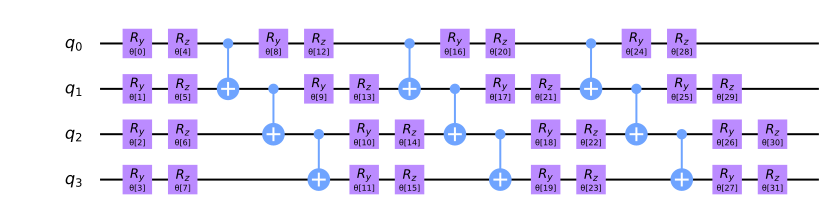


=============Full Entanglement:=============


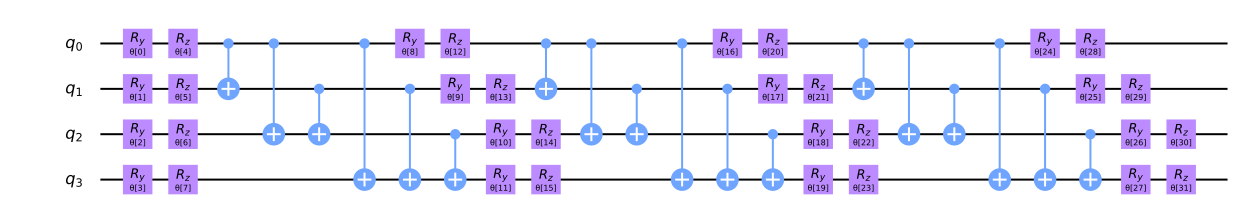

In [20]:
from qiskit.circuit.library import EfficientSU2
entanglements = ["linear", "full"]
for entanglement in entanglements:
    form = EfficientSU2(num_qubits=4, entanglement=entanglement)
    if entanglement == "linear":
        print("=============Linear Entanglement:=============")
    else:
        print("=============Full Entanglement:=============")
    # We initialize all parameters to 0 for this demonstration
    display(form.draw(fold=100))
    print()

深さの設定を $d$ とします。この時、RyRz は $n\times (d+1)\times 2$ 個のパラメーターを持ち、linear エンタングルメントの Ry は $2n\times(d + \frac{1}{2})$ 個のパラメーター、また Ryで full エンタングルメントの場合は、$d\times n\times \frac{(n + 1)}{2} + n$ 個のパラメーターを持つようになります。

## Qiskit での VQE 実装<a id='implementation'></a>
このセクションでは、プログラミングアプローチでのVQEの実装例を示します。Qiskit Aqua では宣言的な実装もできますが、この場合動作しているアルゴリズムの情報が表面に出てきません。このコードは、特に量子ビット操作の準備は、Qiskit チュートリアルリポジトリに基づいています(リポジトリは 2019年7月の時点で https://github.com/Qiskit/qiskit-tutorials　にあります）。

次のライブラリを最初にインポートします。


In [21]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.providers.aer import noise
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

### VQEを状態ベクトルシミュレーターで実行する<a id='implementationstatevec'></a>
様々な原子間距離での LiH の基底エネルギーの計算をデモンストレーションしてみます。各距離での分子ドライバーを作成する必要があります。この実験では、利用する量子ビットの数を減らすため、内核固定(frozen core)し、２つの非占有起動を削除していることに注意してください。最初に、原子間距離を引数とし、適切な量子ビット演算子 $H$ と演算子に関するその他の情報を返却する関数を定義します。


In [22]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = qubitOp.two_qubit_reduced_operator(num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

最初に、正確な基底状態エネルギーを、量子ビット演算子及び古典的固有値計算法(ExactEigensolver)を使って計算します。次に、初期状態 $|\psi\rangle$ を作成し、これを使って VQE が最終的 ansatz $\min_{\theta}(|\psi(\theta)\rangle)$ を生成するようにします。各原子間距離での正確な値と VQEの結果を記録します。`vqe.run(backend)['energy'] + shift` で与えられる結果と $\min_{\theta}\left(\langle \psi(\theta)|H|\psi(\theta)\rangle\right)$ 量は同じであることに着目してください。ここでは、最小はかならずしももっとも最小ではありません。

`VQE(qubitOp, var_form, optimizer, 'matrix')` で VQE インスタンスを初期化する時には、$|\psi(\theta)\rangle$ に対する $H$ の期待値は行列の掛け算で直接計算しています。しかしながら、実量子デバイスや、`VQE(qubitOp, var_form, optimizer, 'paulis')` を使った `qasm_simulator`などの実シミュレーターの場合は、期待値の計算はより複雑になります。ハミルトニアンはパウリストリング (Pauli strings - パウリ行列のテンソル積)の足し算で表現され、使用したマッピングで指定されたパウリ項が、量子ビットに適用されます。$|\psi(\theta)\rangle$ に対応した回路の後に、各パウリストリングに対応する回路が追加されます。結果的に、これらの回路が実行されると、$|\psi(\theta)\rangle$ に対する $H$ の期待値の決定に利用できます。以下の例では、VQE のインスタンスを `matrix` モードで初期化しているので、期待値の計算には行列の掛け算を通じて直接計算しています。

注意： 以下のコードは完了までしばらく時間がかかります。

In [8]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -7.0397102110744365 Exact Energy: [-7.03973252]
Interatomic Distance: 0.6 VQE Result: -7.313344307429222 Exact Energy: [-7.31334583]
Interatomic Distance: 0.7 VQE Result: -7.500921095774594 Exact Energy: [-7.50092209]
Interatomic Distance: 0.8 VQE Result: -7.630976917192274 Exact Energy: [-7.63097825]
Interatomic Distance: 0.9 VQE Result: -7.720810793370067 Exact Energy: [-7.72081241]
Interatomic Distance: 1.0 VQE Result: -7.78224065357088 Exact Energy: [-7.7822424]
Interatomic Distance: 1.1 VQE Result: -7.823597493424521 Exact Energy: [-7.82359928]
Interatomic Distance: 1.2 VQE Result: -7.850696621781857 Exact Energy: [-7.85069838]
Interatomic Distance: 1.3 VQE Result: -7.867561602841405 Exact Energy: [-7.86756329]
Interatomic Distance: 1.4 VQE Result: -7.8769998769059635 Exact Energy: [-7.87700149]
Interatomic Distance: 1.5 VQE Result: -7.88101417428557 Exact Energy: [-7.88101572]
Interatomic Distance: 1.6 VQE Result: -7.881070662592036 Exact Ene

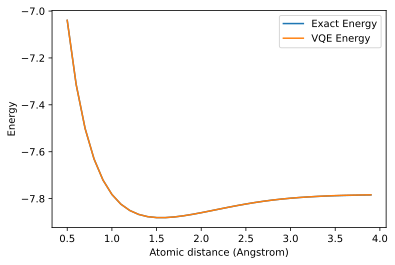

In [49]:
# Note: If you experience BrokenProcessPool error in the next 
#       section, delete this cell and restart the kernel.
#       The error is due to a bug in qiskit and is being looked into.
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

VQEの結果は、正確な値と非常に近いことに着目してください。そのため、正確な値のカーブは VQEカーブに隠れてしまっています。

### VQE をノイズのあるシミュレーターで実行する<a id='implementationnoisy'></a>

ここでは、H$_2$ の基底状態エネルギーの計算に、ノイズのあるシミュレーターとエラー軽減を利用してみます。

最初に、分子のハミルトニアンを表現する量子ビット演算子を用意します:

In [8]:
driver = PySCFDriver(atom='H .0 .0 -0.3625; H .0 .0 0.3625', unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
molecule = driver.run()
num_particles = molecule.num_alpha + molecule.num_beta
qubitOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals).mapping(map_type='parity')
qubitOp = qubitOp.two_qubit_reduced_operator(num_particles)

次に、デバイスのカップリングマップとノイズモデルを IBMQ プロバイダーからロードし、量子インスタンスを作成し、エラー軽減を有効にします:

In [9]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmqx4")
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(device.properties())
quantum_instance = QuantumInstance(backend=backend, shots=1000, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30,)

最後に、オプティマイザー、変分フォーム、および VQE インスタンスを構成します。２量子ビット回路の深さが増すにつれて、ノイズの効果が増加するため、ここでは UCCSD ではなく、発見的な変分フォーム (RYRZ)を利用します。RYRZは、UCCSDに比べ浅い回路で、実質的により少ない２量子ビットゲート数となります。

注意：以下のコードは完了までしばらく時間がかかります。

In [10]:
exact_solution = NumPyEigensolver(qubitOp).run()
print("Exact Result:", np.real(exact_solution.eigenvalues))
optimizer = SPSA(max_trials=100)
var_form = EfficientSU2(qubitOp.num_qubits, entanglement="linear")
vqe = VQE(qubitOp, var_form, optimizer=optimizer)
ret = vqe.run(quantum_instance)
vqe_result = np.real(ret['eigenvalue'])
print("VQE Result:", vqe_result)

Exact Result: [-1.86712098]
VQE Result: -1.82409014969285


たとえ結果が化学有効値(正しい結果に対して 0.0016 Hartree と定義されている)になっていませんが、ノイズ軽減が有効な場合、正確な値にかなり近いと言えるでしょう。

## 問題<a id='problems'></a>
1. 基底状態が $n$ 量子ビットの最大エンタングルに近いことが約束されている、ハミルトニアン $H$ が与えられているとする。どの変分フォームが、$H$ の基底状態エネルギーを効率的かつ正確に与えるかを説明せよ。ここでは自作の変分フォームを使ってもよい。その場合、このハミルトニアンになぜそれが適切かを説明せよ。

2. COPYLAオプティマイザーと 1000ショットの `qasm_simulator`、および 60パウリストリングをもったハミルトニアンを使う場合、１回の最適化の際に行われる回路評価数を計算せよ。

3. 原子間距離が $1.3$Å の BeH$_2$ の基底状態エネルギーを推定せよ。`get_qubit_op(dist)` 関数を再利用する場合、`atom="Li .0 .0 .0; H .0 .0 " + str(dist)` を、`atom="Be .0 .0 .0; H .0 .0 -" + str(dist) + "; H .0 .0 " + str(dist)` で置き換え、`get_qubit_op(1.3)` を実行する。この分子の場合、非占有軌道の削除をすると、化学的な正確性が失われることに注意すること。しかしながら、必要となる量子ビット数を6まで下げる（多くのラップトップで効果的なシミュレーションができるようにする）場合は、このロスは許容範囲である。興味のある読者は、必要する量子ビット数を 7 までにして化学正確性を失わないように試みてもよい。

## 参考文献<a id='references'></a>
1. Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." *Nature communications* 5 (2014): 4213.
2. Griffiths, David J., and Darrell F. Schroeter. Introduction to quantum mechanics. *Cambridge University Press*, 2018.
3. Shende, Vivek V., Igor L. Markov, and Stephen S. Bullock. "Minimal universal two-qubit cnot-based circuits." arXiv preprint quant-ph/0308033 (2003).
4. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." Nature 549.7671 (2017): 242.

In [ ]:
import qiskit
qiskit.__qiskit_version__